In [21]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for number crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

/kaggle/input/online-retail-ii-uci/online_retail_II.csv


In [22]:
os.listdir('/kaggle/input/online-retail-ii-uci')

['online_retail_II.csv']

In [23]:
data = pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv')

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [24]:
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


# Creating the necessary columns

In [25]:
# Making sure Date is in datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Total ammount column
data['TotalAmount'] = data['Price'] * data['Quantity']

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


# Dropping null columns

In [26]:
# Validating null values
data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
TotalAmount         0
dtype: int64

In [27]:
# Validating negative values
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price              5
Quantity       22950
TotalAmount    19498
dtype: int64

In [28]:
# Deleting all rows with null values
data = data.dropna(subset = ['Customer ID'])

# Eliminating rows with negative quantities

# Note: don't eliminate this data, TO BE DETERMINED

data = data[data['Quantity'] >= 0]

data = data[data['Price'] >= 0]

In [29]:
# Validating null values again
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalAmount    0
dtype: int64

In [30]:
# Validating negative values again
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price          0
Quantity       0
TotalAmount    0
dtype: int64

# Price, Quantity and Total Amount distributions

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Quantity', ylabel='Percent'>

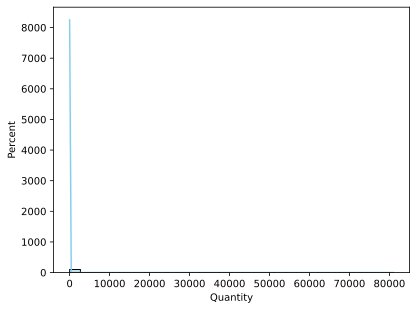

In [31]:
sns.histplot(data['Quantity'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Price', ylabel='Percent'>

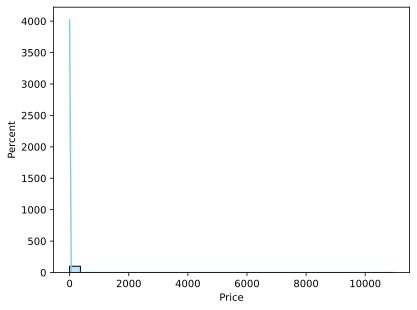

In [32]:
sns.histplot(data['Price'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='TotalAmount', ylabel='Percent'>

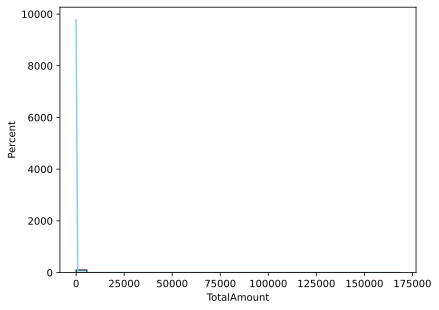

In [33]:
sns.histplot(data['TotalAmount'],bins=30, kde=True, color="skyblue", stat="percent")

In [34]:
# Distribution for Quantity
print(data['Quantity'].describe())

count    805620.000000
mean         13.307665
std         144.306739
min           1.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64


In [35]:
# Distribution for Price
print(data['Price'].describe())

count    805620.000000
mean          3.206279
std          29.197901
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       10953.500000
Name: Price, dtype: float64


In [36]:
# Distribution for Total Amount
print(data['TotalAmount'].describe())

count    805620.000000
mean         22.024564
std         224.032150
min           0.000000
25%           4.950000
50%          11.850000
75%          19.500000
max      168469.600000
Name: TotalAmount, dtype: float64


In [38]:
#Dropping the outliers from data and saving them on other dataset!
dataOutliersQuantity = data[data['Quantity'] > data['Quantity'].quantile(0.98)]
dataOutliersPrice = data[data['Price'] > data['Price'].quantile(0.98)]
dataOutliersTotalAmount = data[data['TotalAmount'] > data['TotalAmount'].quantile(0.98)]

data = data[data['Quantity'] < data['Quantity'].quantile(0.98)]
data = data[data['Price'] < data['Price'].quantile(0.98)]
data = data[data['TotalAmount'] < data['TotalAmount'].quantile(0.98)]

# Podemos hacer un estudio aparte de los outliers como explica el profe Juan Trabucco para no ignorar esta data!
# Segmentar los datos que voy a modelar con mi NN y los que no (estos outliers).
# 
# Punto importante: Toda la data esta distribuida en Gamma.
# 
# Sacarle el log a cantidad y precio para ver la verdadera distribucion centrada y ver si podemos usar la data con esta 
# transformacion enves de eliminarla.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Quantity', ylabel='Percent'>

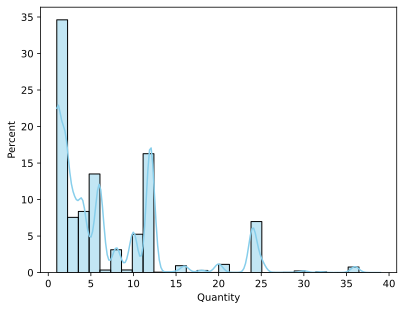

In [39]:
sns.histplot(data['Quantity'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Price', ylabel='Percent'>

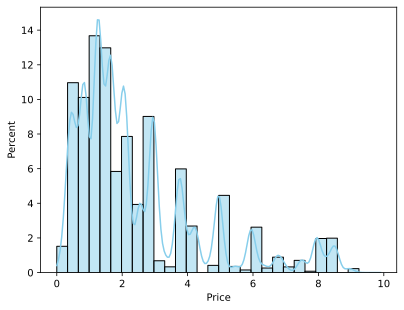

In [40]:
sns.histplot(data['Price'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='TotalAmount', ylabel='Percent'>

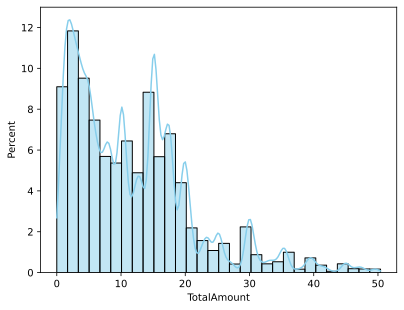

In [41]:
sns.histplot(data['TotalAmount'],bins=30, kde=True, color="skyblue", stat="percent")